In [62]:
import argparse, os, time
import pandas as pd
import geopandas as gpd
import polars as pl
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import ScalarFormatter, FuncFormatter
import matplotlib.patheffects as path_effects
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from collections import defaultdict
import warnings
from tqdm import tqdm
import pickle

tqdm.pandas()
warnings.filterwarnings("ignore")

In [63]:
year = 20
donors_csv = f"./output/donors_state{year}_pred_lastname.csv"

In [64]:
donors = pd.read_csv(donors_csv)
donors.head(10)

,contrib_id,name,name_new,orgname,ultorg,realcode,gender,occupation,employer,city,state,total_donated,donation_count,avg_donation,med_donation,lastname,ethnic
0,,ACTBLUE,actblue actblue,NaN,NaN,Y4000,,NaN,NaN,WASHINGTON,CA,1.261253e+09,25821,4.884603e+04,1000.0,actblue,not
1,U00000037041,"BLOOMBERG, MICHAEL R",michael r bloomberg,[Candidate Contribution],NaN,Z9000,M,FOUNDER,BLOOMBERG INC.,NEW YORK,NY,1.127731e+09,958,1.177172e+06,682.5,bloomberg,not
2,U00000036521,"STEYER, TOM",tom steyer,[Candidate Contribution],NaN,Z9000,M,PRESIDENTIAL CANDIDATE,SELF-EMPLOYED,SAN FRANCISCO,CA,3.794782e+08,756,5.019553e+05,2800.0,steyer,not
3,U00000046841,"MELLON, TIMOTHY",timothy mellon,Investments,NaN,F7000,M,INVESTMENTS,SELF-EMPLOYED,SARATOGA,WY,4.513356e+07,23,1.962328e+06,2800.0,mellon,not
4,U0000000310A,"ADELSON, MIRIAM",miriam adelson,Adelson Clinic for Drug Abuse Treatment & Rese...,NaN,H3200,F,PHYSICIAN,ADELSON CLINIC,LAS VEGAS,NV,4.499955e+07,124,3.628996e+05,2800.0,adelson,not
5,U00000003101,"ADELSON, SHELDON G",sheldon g adelson,Las Vegas Sands,NaN,G6500,M,CEO,LAS VEGAS SANDS CORPORATION,LAS VEGAS,NV,4.484795e+07,119,3.768735e+05,2800.0,adelson,not
6,U00000036901,"UIHLEIN, RICHARD",richard uihlein,Uline Inc,NaN,M7000,M,CEO,ULINE,LAKE FOREST,IL,3.536433e+07,319,1.108600e+05,2800.0,uihlein,not
7,U00000036551,"GRIFFIN, KENNETH",kenneth griffin,Citadel LLC,NaN,F2700,M,FOUNDER CEO,CITADEL LLC,CHICAGO,IL,3.366763e+07,188,1.790832e+05,2800.0,griffin,not
8,U00000003611,"SCHWARZMAN, STEPHEN A",stephen a schwarzman,Blackstone Group,NaN,F2600,M,CHAIRMAN,BLACKSTONE,NEW YORK,NY,3.345400e+07,226,1.480265e+05,2800.0,schwarzman,not
9,U00000046781,"JURVETSON, KARLA",karla jurvetson,Karla T Jurvetson MD,NaN,H1110,F,PHYSICIAN,SELF,LOS ALTOS,CA,3.308810e+07,914,3.620142e+04,2800.0,jurvetson,not


In [65]:
len(donors)

3588936

In [66]:
print(donors.sort_values(by="total_donated", ascending=False).head(10000)['total_donated'].sum()/donors["total_donated"].sum()*100)
donors.sort_values(by="total_donated", ascending=False).head(10)

52.08035503339197


,contrib_id,name,name_new,orgname,ultorg,realcode,gender,occupation,employer,city,state,total_donated,donation_count,avg_donation,med_donation,lastname,ethnic
0,,ACTBLUE,actblue actblue,NaN,NaN,Y4000,,NaN,NaN,WASHINGTON,CA,1.261253e+09,25821,4.884603e+04,1000.0,actblue,not
1,U00000037041,"BLOOMBERG, MICHAEL R",michael r bloomberg,[Candidate Contribution],NaN,Z9000,M,FOUNDER,BLOOMBERG INC.,NEW YORK,NY,1.127731e+09,958,1.177172e+06,682.5,bloomberg,not
2,U00000036521,"STEYER, TOM",tom steyer,[Candidate Contribution],NaN,Z9000,M,PRESIDENTIAL CANDIDATE,SELF-EMPLOYED,SAN FRANCISCO,CA,3.794782e+08,756,5.019553e+05,2800.0,steyer,not
3,U00000046841,"MELLON, TIMOTHY",timothy mellon,Investments,NaN,F7000,M,INVESTMENTS,SELF-EMPLOYED,SARATOGA,WY,4.513356e+07,23,1.962328e+06,2800.0,mellon,not
4,U0000000310A,"ADELSON, MIRIAM",miriam adelson,Adelson Clinic for Drug Abuse Treatment & Rese...,NaN,H3200,F,PHYSICIAN,ADELSON CLINIC,LAS VEGAS,NV,4.499955e+07,124,3.628996e+05,2800.0,adelson,not
5,U00000003101,"ADELSON, SHELDON G",sheldon g adelson,Las Vegas Sands,NaN,G6500,M,CEO,LAS VEGAS SANDS CORPORATION,LAS VEGAS,NV,4.484795e+07,119,3.768735e+05,2800.0,adelson,not
6,U00000036901,"UIHLEIN, RICHARD",richard uihlein,Uline Inc,NaN,M7000,M,CEO,ULINE,LAKE FOREST,IL,3.536433e+07,319,1.108600e+05,2800.0,uihlein,not
7,U00000036551,"GRIFFIN, KENNETH",kenneth griffin,Citadel LLC,NaN,F2700,M,FOUNDER CEO,CITADEL LLC,CHICAGO,IL,3.366763e+07,188,1.790832e+05,2800.0,griffin,not
8,U00000003611,"SCHWARZMAN, STEPHEN A",stephen a schwarzman,Blackstone Group,NaN,F2600,M,CHAIRMAN,BLACKSTONE,NEW YORK,NY,3.345400e+07,226,1.480265e+05,2800.0,schwarzman,not
9,U00000046781,"JURVETSON, KARLA",karla jurvetson,Karla T Jurvetson MD,NaN,H1110,F,PHYSICIAN,SELF,LOS ALTOS,CA,3.308810e+07,914,3.620142e+04,2800.0,jurvetson,not


In [67]:
donors[donors["ethnic"] == "ind"].sort_values(by="total_donated", ascending=False).head(10)

,contrib_id,name,name_new,orgname,ultorg,realcode,gender,occupation,employer,city,state,total_donated,donation_count,avg_donation,med_donation,lastname,ethnic
149,U00000033011,"KHOSLA, VINOD",vinod khosla,Khosla Ventures,NaN,F2500,M,VENTURE CAPITALIST,KHOSLA VENTURES,PORTOLA VALLEY,CA,2410795.0,56,43049.910714,2224.0,khosla,ind
264,m0001327150,"GANDHI, SAMEER",sameer gandhi,Accel Partners,NaN,F2500,M,VENTURE CAPITALIST,ACCEL,SAN FRANCISCO,CA,1629499.0,110,14813.627273,10000.0,gandhi,ind
340,i30032161751,"CHANDI, NACHHATTAR",nachhattar chandi,Chandi Group Usa,NaN,F4100,M,OWNER,CHANDI GROUP USA,INDIO,CA,1311745.0,104,12612.932692,1572.5,chandi,ind
349,h10013502001,"REDDY, PREM",prem reddy,Prime Healthcare Services,NaN,H1100,M,FOUNDER/CHIEF EXECUTIVE OFFICER,PRIME HEALTHCARE SERVICES,VICTORVILLE,CA,1297700.0,59,21994.915254,10000.0,reddy,ind
373,p00053429381,"MANTENA, RAMALINGA",ramalinga mantena,Integra Connect,NaN,H3900,F,SELF-EMPLOYED,INTEGRA CONNECT LLC,JUPITER,FL,1241200.0,45,27582.222222,10000.0,mantena,ind
377,U0000004388A,"MANTENA, PADMAJA",padmaja mantena,Integra Connect,NaN,H3900,F,HOMEMAKER,HOMEMAKER,JUPITER,FL,1235200.0,47,26280.851064,10000.0,mantena,ind
492,h3003465387,"AYYADURAI, SHIVA",shiva ayyadurai,[Candidate Contribution],NaN,Z9000,U,CHAIRMAN & CEO,"CYTOSOLVE, INC.",BELMONT,MA,1044900.0,21,49757.142857,2000.0,ayyadurai,ind
522,U0000004761,"SINGH, NISHAD",nishad singh,FTX.US,NaN,F2800,M,DIRECTOR OF ENGINEERING,ALAMEDA RESEARCH LLC,SAN FRANCISCO,CA,1000000.0,1,1000000.000000,1000000.0,singh,ind
529,h3001220400,"MULYE, NIRMAL",nirmal mulye,Nostrum Pharmaceuticals,NaN,H4300,M,CHAIRMAN,NOSTRUM PHARMACEUTICALS,MIAMI,FL,986499.0,69,14297.086957,7068.0,mulye,ind
611,r0007027508,"SAMBASIVAM, SIVAKAMI",sivakami sambasivam,Goodrx,NaN,H4400,U,NaN,GOODRX,SANTA MONICA,CA,860763.0,238,3616.651261,1190.0,sambasivam,ind


In [68]:
print(donors["total_donated"].sum())
print(donors[donors["ethnic"] == "ind"]["total_donated"].sum())
print((donors[donors["ethnic"] == "ind"]["total_donated"].sum()/donors["total_donated"].sum())*100, "% of donated amount is from diaspora")

12004197961.0
80911468.0
0.6740264386081463 % of donated amount is from diaspora


In [69]:
print(len(donors))
print(len(donors[donors["ethnic"] == "ind"]))
print((len(donors[donors["ethnic"] == "ind"])/len(donors))*100, "% of donors are from diaspora")

3588936
21028
0.5859118134176815 % of donors are from diaspora


In [70]:
print(donors["donation_count"].median())
print(donors[donors["ethnic"] == "ind"]["donation_count"].median())

3.0
2.0


In [71]:
print(donors["total_donated"].median())
print(donors[donors["ethnic"] == "ind"]["total_donated"].median())

432.0
575.0


In [72]:
print(donors["total_donated"].mean())
print(donors[donors["ethnic"] == "ind"]["total_donated"].mean())

3344.7790545721627
3847.796652082937


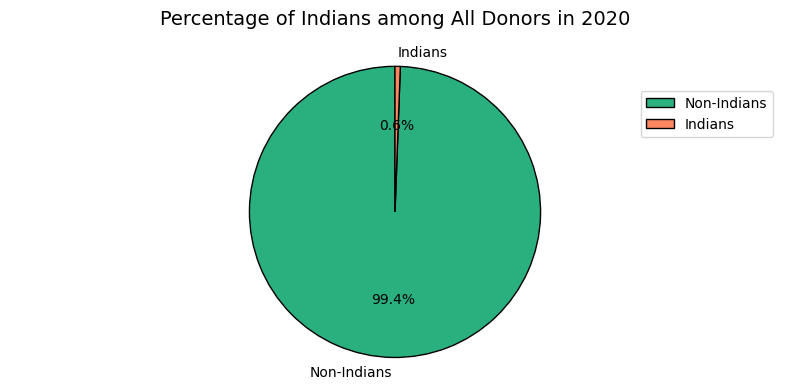

In [73]:
indian_counts = donors['ethnic'].value_counts()

plt.figure(figsize=(8, 4))
plt.pie(indian_counts, 
        labels=['Non-Indians', 'Indians'], 
        colors=['#2ab07f', '#fb8761'], 
        autopct='%1.1f%%', 
        startangle=90,
        wedgeprops={'linewidth': 1, 'edgecolor': 'black'},
        textprops={'fontsize': 10})

plt.title(f'Percentage of Indians among All Donors in 20{year}', pad=20, fontsize=14)
plt.axis('equal')
plt.legend(loc='upper right', bbox_to_anchor=(1, 0.9))
plt.tight_layout()
plt.show()

In [74]:
mapping = {
    'A': 'Agribusiness',
    'B': 'Construction',
    'C': 'Tech',
    'D': 'Defense',
    'E': 'Energy',
    'F': 'Finance',
    'M': 'Misc Business',
    'H': 'Health',
    'J': 'Ideology/Single Issue',
    'K': 'Law',
    'L': 'Labor',
    'M': 'Manufacturing',
    'T': 'Transportation',
    'W': 'Other',
    'Y': 'Unknown',
    'Z': 'Party'
}

donors["sector"] = donors["realcode"].apply(lambda x: str(x).upper()[0]).map(mapping)
donors["sector"].value_counts()

sector
Unknown                  680118
Party                    457704
Ideology/Single Issue    351066
Health                   306837
Finance                  232336
Tech                     122934
Labor                    106811
Law                       79766
Transportation            75121
Construction              66659
Energy                    58773
Agribusiness              43488
Manufacturing             31758
Defense                   26274
Name: count, dtype: int64

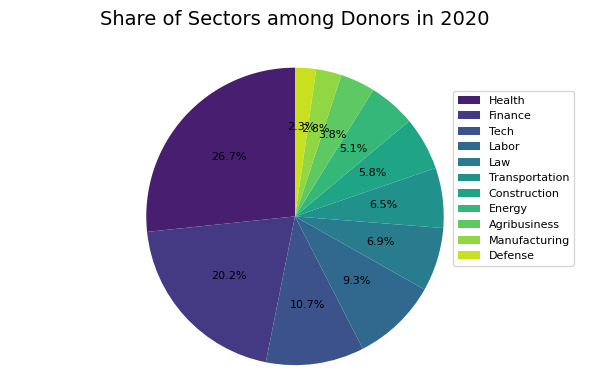

In [80]:
employ_counts = donors['sector'].apply(lambda x: "Other" if x in ["Unknown", "Party", "Ideology/Single Issue"] else x).value_counts().iloc[1:]

plt.figure(figsize=(6, 4))

wedges, _, _ = plt.pie(
    employ_counts,
    labels=None,
    colors=sns.color_palette("viridis", n_colors=len(employ_counts)),
    autopct='%1.1f%%',
    startangle=90,
    textprops={'fontsize': 8}
)

plt.title(f'Share of Sectors among Donors in 20{year}', pad=20, fontsize=14)
plt.axis('equal')
plt.legend(wedges, employ_counts.index, loc='upper right', bbox_to_anchor=(1, 0.9), fontsize=8)
plt.tight_layout()
plt.show()

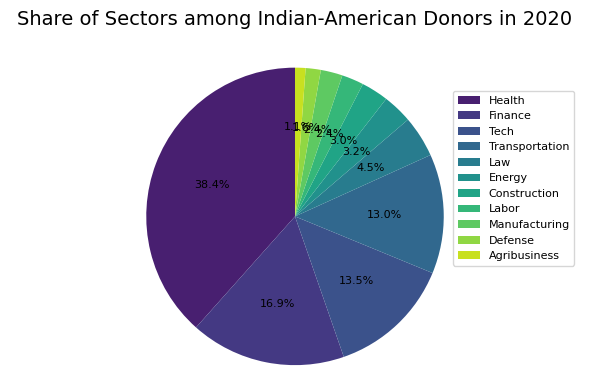

In [81]:
employ_counts_indian = donors[donors['ethnic'] == 'ind']['sector'].apply(lambda x: "Other" if x in ["Unknown", "Party", "Ideology/Single Issue"] else x).value_counts().iloc[1:]

plt.figure(figsize=(6, 4))

wedges, _, _ = plt.pie(
    employ_counts_indian,
    labels=None,
    colors=sns.color_palette("viridis", n_colors=len(employ_counts_indian)),
    autopct='%1.1f%%',
    startangle=90,
    textprops={'fontsize': 8}
)

plt.title(f'Share of Sectors among Indian-American Donors in 20{year}', pad=20, fontsize=14)
plt.axis('equal')
plt.legend(wedges, employ_counts_indian.index, loc='upper right', bbox_to_anchor=(1, 0.9), fontsize=8)
plt.tight_layout()
plt.show()